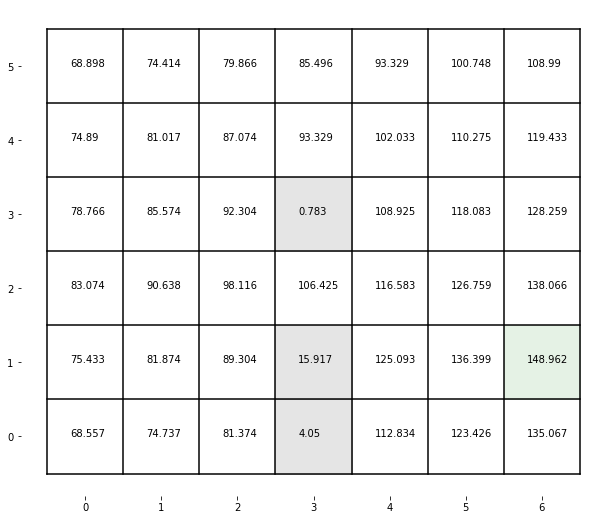

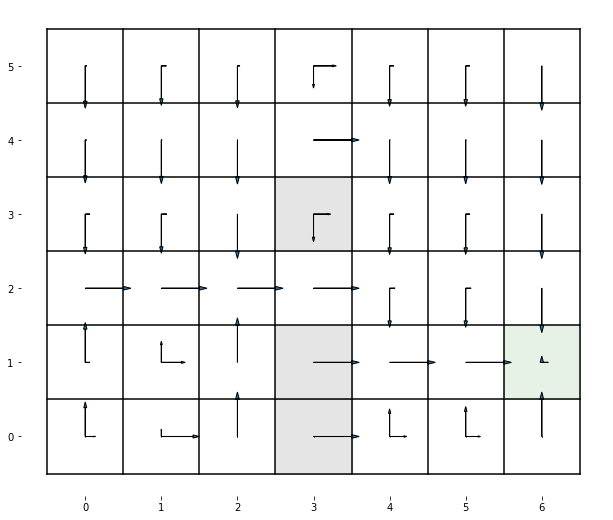

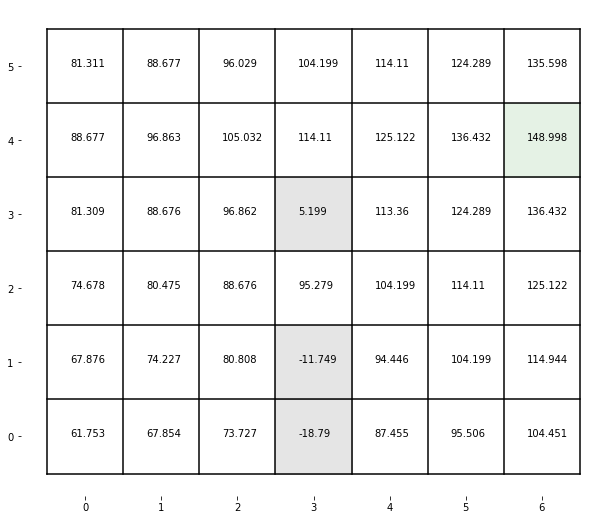

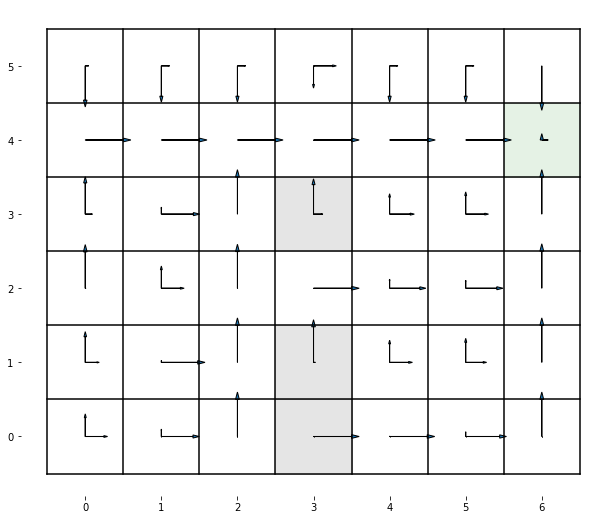

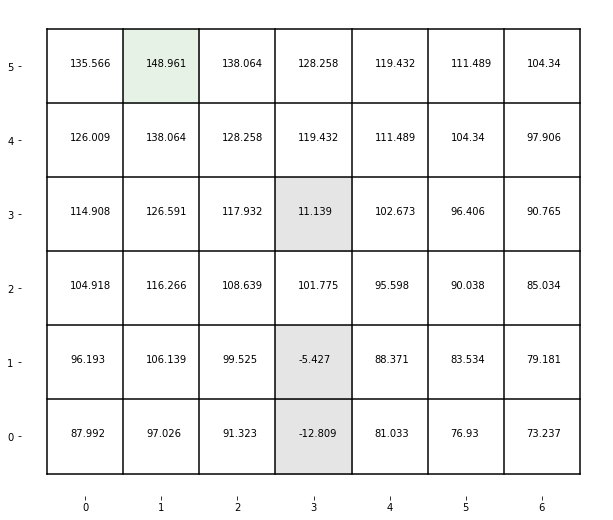

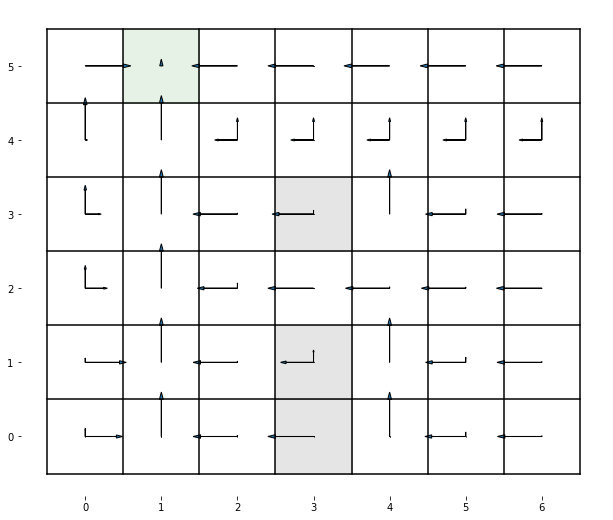

In [ ]:

"""
Class: Stat232C
Project 4: Signaling Policy
Name:
Date: May 14, 2020

Goal:   return the new reward function
        get a policy that reflects signaling to an observer for each possible true goal in the environment.
        visualize the policy as before by providing graphs of the value table and policy
        write a brief commentary on what has changed between the original goal policies and the new signaling policies.
"""

import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Rectangle

class GetLikelihoodReward(object):
    def __init__(self, transitionTable, goalPolicies):
        self.transitionTable = transitionTable
        self.goalPolicies  = goalPolicies #can be dictionary of form goal:goal policy or a list, but trueGoal should link to the correct policy here

    def __call__(self, trueGoal, originalReward, alpha):
    	######################################
    	###### Your Code Here ################
    	######################################
      newReward = originalReward.copy()
      for current_state in self.transitionTable:
        for action in self.transitionTable[current_state]:
          for next_state in self.transitionTable[current_state][action]: 
            r0 = self.goalPolicies[current_state][action][next_state][0]
            r1 = self.goalPolicies[current_state][action][next_state][1]
            r2 = self.goalPolicies[current_state][action][next_state][2]
            r_info = 0; 
            if trueGoal == "A": 
              r_info = r0/(r0+r1+r2)
            else:
              if trueGoal == "B": 
                r_info = r1/(r0+r1+r2)
              else:
                if trueGoal == "C": 
                  r_info = r2/(r0+r1+r2); 
            newReward[current_state][action][next_state] = originalReward[current_state][action][next_state] + alpha * r_info 
      return(newReward)

class ValueIteration(object):
    def __init__(self, transitionTable, rewardTable, valueTable, convergenceTolerance, gamma, beta):
        self.transitionTable = transitionTable
        self.rewardTable  = rewardTable
        self.valueTable = valueTable
        self.convergenceTolerance = convergenceTolerance
        self.gamma = gamma
        self.beta = beta

    def __call__(self):
      policyTable = {}
      while True:
        delta = 0
        valueTable_next = self.valueTable.copy()

        for i in self.valueTable:
          temp = {}
          for j in self.transitionTable[i]: 
            temp[j] = 0
            for k in self.transitionTable[i][j]: 
              temp[j] += self.transitionTable[i][j][k] * (self.rewardTable[i][j][k] + self.gamma*self.valueTable[k])
              
          valueTable_next[i] = temp[j]
          for l in temp:
            if(valueTable_next[i] < temp[l]):
              valueTable_next[i] = temp[l] 
        
          delta = max(delta, abs(valueTable_next[i] - self.valueTable[i]))
        
        self.valueTable = valueTable_next.copy()

        if (delta < self.convergenceTolerance):
          for i in self.valueTable:
            q = {}
            for j in self.transitionTable[i]: 
              q[j] = 0
              for k in self.transitionTable[i][j]: 
                q[j] += self.transitionTable[i][j][k] * (self.rewardTable[i][j][k] + self.gamma*self.valueTable[k])
                policyTable = policyTable_set(policyTable,j,i,q[j], self.beta)

        
          for state in policyTable:
            total = 0
            for action in policyTable[state]:
              total += policyTable[state][action]

            for action in policyTable[state]:
              policyTable[state][action] /= total 
          break

      return ([self.valueTable, policyTable])

def policyTable_set(policyTable, action, state, q, beta):
    if state in policyTable:
        if action in policyTable[state]:
            policyTable[state][action] = math.exp(beta*q)
        else:
            policyTable[state].update({action:math.exp(beta*q)})
    else:
        policyTable.update({state:{action:math.exp(beta*q)}})
    return policyTable

def goal_predict(transitionTable, policyTableA, policyTableB, policyTableC):
    next_state_set = {}; 
    for current_state in transitionTable:
      for action in transitionTable[current_state]:
        for next_state in transitionTable[current_state][action]: 
          if current_state in next_state_set:
            if action in next_state_set[current_state]:
              if next_state in next_state_set[current_state][action]:
                next_state_set[current_state][action][next_state][0] = 0
              else:
                next_state_set[current_state][action][next_state] = {0:0}
            else:
              next_state_set[current_state][action]={next_state:{0:0}}
          else:
            next_state_set[current_state]= {action:{next_state:{0:0}}}
            
          next_state_set[current_state][action][next_state][1] = 0
          next_state_set[current_state][action][next_state][2] = 0 

          for j in policyTableA[current_state]:
            if next_state in transitionTable[current_state][j]:
              next_state_set[current_state][action][next_state][0] += transitionTable[current_state][j][next_state] * policyTableA[current_state][j]
        
          for j in policyTableB[current_state]:
            if next_state in transitionTable[current_state][j]:
              next_state_set[current_state][action][next_state][1] += transitionTable[current_state][j][next_state] * policyTableB[current_state][j]
    
          for j in policyTableC[current_state]:
            if next_state in transitionTable[current_state][j]:
              next_state_set[current_state][action][next_state][2] += transitionTable[current_state][j][next_state] * policyTableC[current_state][j]
  
    return next_state_set

def visualizeValueTable(gridWidth, gridHeight, goalState, trapStates, valueTable):
    gridAdjust = .5
    gridScale = 1.5
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
    plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
    ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

    #goal and trap coloring 
    ax.add_patch(Rectangle((goalState[0]-gridAdjust, goalState[1]-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    
    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))
    
    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color = "black")
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color = "black")

    #labeled values
    for (statex, statey), val in valueTable.items():
        plt.text(statex-.2, statey, str(round(val, 3)))    

    plt.show()


def visualizePolicy(gridWidth, gridHeight, goalState, trapStates, policy):
    #grid height/width
    gridAdjust = .5
    gridScale = 1.5
    arrowScale = .5
    
    xs = np.linspace(-gridAdjust, gridWidth-gridAdjust, gridWidth+1)
    ys = np.linspace(-gridAdjust, gridHeight-gridAdjust, gridHeight+1)
    
    plt.rcParams["figure.figsize"] = [gridWidth*gridScale,gridHeight*gridScale]
    ax = plt.gca(frameon=False, xticks = range(gridWidth), yticks = range(gridHeight))

    #goal and trap coloring 
    ax.add_patch(Rectangle((goalState[0]-gridAdjust, goalState[1]-gridAdjust), 1, 1, fill=True, color='green', alpha=.1))
    
    for (trapx, trapy) in trapStates:
        ax.add_patch(Rectangle((trapx-gridAdjust, trapy-gridAdjust), 1, 1, fill=True, color='black', alpha=.1))

    # grid lines
    for x in xs:
        plt.plot([x, x], [ys[0], ys[-1]], color = "black")
    for y in ys:
        plt.plot([xs[0], xs[-1]], [y, y], color = "black")

    #labeled values
    for (statex, statey), actionDict in policy.items():
        for (optimalActionX, optimalActionY), actionProb in actionDict.items():
            plt.arrow(statex, statey, optimalActionX*actionProb*arrowScale, optimalActionY*actionProb*arrowScale, head_width=0.05*actionProb, head_length=0.1*actionProb)    

    plt.show()

def viewDictionaryStructure(d, levels, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(levels[indent]) + ": "+ str(key))
        if isinstance(value, dict):
            viewDictionaryStructure(value, levels, indent+1)
        else:
            print('\t' * (indent+1) + str(levels[indent+1])+ ": " + str(value))


# Parameters across all goals and environments
convergenceThreshold = 10e-7
gamma = .9
beta = 2
alpha = 5

"""
	Environment specifications
	gridWidth = 7
	gridHeight = 6
	allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]
	trapStates = [(3,0), (3,1), (3,3)]
	goalA = (6,1)
	goalB = (6,4)
	goalC = (1,5)
"""

transition = {(0, 0): {(1, 0): {(1, 0): 1},(0, 1): {(0, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(0, 0): 1},(0, 0): {(0, 0): 1}},(0, 1): {(1, 0): {(1, 1): 1},(0, 1): {(0, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(0, 0): 1},(0, 0): {(0, 1): 1}},(0, 2): {(1, 0): {(1, 2): 1},(0, 1): {(0, 3): 1},(-1, 0): {(0, 2): 1},(0, -1): {(0, 1): 1},(0, 0): {(0, 2): 1}},(0, 3): {(1, 0): {(1, 3): 1},(0, 1): {(0, 4): 1},(-1, 0): {(0, 3): 1},(0, -1): {(0, 2): 1},(0, 0): {(0, 3): 1}},(0, 4): {(1, 0): {(1, 4): 1},(0, 1): {(0, 5): 1},(-1, 0): {(0, 4): 1},(0, -1): {(0, 3): 1},(0, 0): {(0, 4): 1}},(0, 5): {(1, 0): {(1, 5): 1},(0, 1): {(0, 5): 1},(-1, 0): {(0, 5): 1},(0, -1): {(0, 4): 1},(0, 0): {(0, 5): 1}},(1, 0): {(1, 0): {(2, 0): 1},(0, 1): {(1, 1): 1},(-1, 0): {(0, 0): 1},(0, -1): {(1, 0): 1},(0, 0): {(1, 0): 1}},(1, 1): {(1, 0): {(2, 1): 1},(0, 1): {(1, 2): 1},(-1, 0): {(0, 1): 1},(0, -1): {(1, 0): 1},(0, 0): {(1, 1): 1}},(1, 2): {(1, 0): {(2, 2): 1},(0, 1): {(1, 3): 1},(-1, 0): {(0, 2): 1},(0, -1): {(1, 1): 1},(0, 0): {(1, 2): 1}},(1, 3): {(1, 0): {(2, 3): 1},(0, 1): {(1, 4): 1},(-1, 0): {(0, 3): 1},(0, -1): {(1, 2): 1},(0, 0): {(1, 3): 1}},(1, 4): {(1, 0): {(2, 4): 1},(0, 1): {(1, 5): 1},(-1, 0): {(0, 4): 1},(0, -1): {(1, 3): 1},(0, 0): {(1, 4): 1}},(1, 5): {(1, 0): {(2, 5): 1},(0, 1): {(1, 5): 1},(-1, 0): {(0, 5): 1},(0, -1): {(1, 4): 1},(0, 0): {(1, 5): 1}},(2, 0): {(1, 0): {(3, 0): 1},(0, 1): {(2, 1): 1},(-1, 0): {(1, 0): 1},(0, -1): {(2, 0): 1},(0, 0): {(2, 0): 1}},(2, 1): {(1, 0): {(3, 1): 1},(0, 1): {(2, 2): 1},(-1, 0): {(1, 1): 1},(0, -1): {(2, 0): 1},(0, 0): {(2, 1): 1}},(2, 2): {(1, 0): {(3, 2): 1},(0, 1): {(2, 3): 1},(-1, 0): {(1, 2): 1},(0, -1): {(2, 1): 1},(0, 0): {(2, 2): 1}},(2, 3): {(1, 0): {(3, 3): 1},(0, 1): {(2, 4): 1},(-1, 0): {(1, 3): 1},(0, -1): {(2, 2): 1},(0, 0): {(2, 3): 1}},(2, 4): {(1, 0): {(3, 4): 1},(0, 1): {(2, 5): 1},(-1, 0): {(1, 4): 1},(0, -1): {(2, 3): 1},(0, 0): {(2, 4): 1}},(2, 5): {(1, 0): {(3, 5): 1},(0, 1): {(2, 5): 1},(-1, 0): {(1, 5): 1},(0, -1): {(2, 4): 1},(0, 0): {(2, 5): 1}},(3, 0): {(1, 0): {(4, 0): 1},(0, 1): {(3, 1): 1},(-1, 0): {(2, 0): 1},(0, -1): {(3, 0): 1},(0, 0): {(3, 0): 1}},(3, 1): {(1, 0): {(4, 1): 1},(0, 1): {(3, 2): 1},(-1, 0): {(2, 1): 1},(0, -1): {(3, 0): 1},(0, 0): {(3, 1): 1}},(3, 2): {(1, 0): {(4, 2): 1},(0, 1): {(3, 3): 1},(-1, 0): {(2, 2): 1},(0, -1): {(3, 1): 1},(0, 0): {(3, 2): 1}},(3, 3): {(1, 0): {(4, 3): 1},(0, 1): {(3, 4): 1},(-1, 0): {(2, 3): 1},(0, -1): {(3, 2): 1},(0, 0): {(3, 3): 1}},(3, 4): {(1, 0): {(4, 4): 1},(0, 1): {(3, 5): 1},(-1, 0): {(2, 4): 1},(0, -1): {(3, 3): 1},(0, 0): {(3, 4): 1}},(3, 5): {(1, 0): {(4, 5): 1},(0, 1): {(3, 5): 1},(-1, 0): {(2, 5): 1},(0, -1): {(3, 4): 1},(0, 0): {(3, 5): 1}},(4, 0): {(1, 0): {(5, 0): 1},(0, 1): {(4, 1): 1},(-1, 0): {(3, 0): 1},(0, -1): {(4, 0): 1},(0, 0): {(4, 0): 1}},(4, 1): {(1, 0): {(5, 1): 1},(0, 1): {(4, 2): 1},(-1, 0): {(3, 1): 1},(0, -1): {(4, 0): 1},(0, 0): {(4, 1): 1}},(4, 2): {(1, 0): {(5, 2): 1},(0, 1): {(4, 3): 1},(-1, 0): {(3, 2): 1},(0, -1): {(4, 1): 1},(0, 0): {(4, 2): 1}},(4, 3): {(1, 0): {(5, 3): 1},(0, 1): {(4, 4): 1},(-1, 0): {(3, 3): 1},(0, -1): {(4, 2): 1},(0, 0): {(4, 3): 1}},(4, 4): {(1, 0): {(5, 4): 1},(0, 1): {(4, 5): 1},(-1, 0): {(3, 4): 1},(0, -1): {(4, 3): 1},(0, 0): {(4, 4): 1}},(4, 5): {(1, 0): {(5, 5): 1},(0, 1): {(4, 5): 1},(-1, 0): {(3, 5): 1},(0, -1): {(4, 4): 1},(0, 0): {(4, 5): 1}},(5, 0): {(1, 0): {(6, 0): 1},(0, 1): {(5, 1): 1},(-1, 0): {(4, 0): 1},(0, -1): {(5, 0): 1},(0, 0): {(5, 0): 1}},(5, 1): {(1, 0): {(6, 1): 1},(0, 1): {(5, 2): 1},(-1, 0): {(4, 1): 1},(0, -1): {(5, 0): 1},(0, 0): {(5, 1): 1}},(5, 2): {(1, 0): {(6, 2): 1},(0, 1): {(5, 3): 1},(-1, 0): {(4, 2): 1},(0, -1): {(5, 1): 1},(0, 0): {(5, 2): 1}},(5, 3): {(1, 0): {(6, 3): 1},(0, 1): {(5, 4): 1},(-1, 0): {(4, 3): 1},(0, -1): {(5, 2): 1},(0, 0): {(5, 3): 1}},(5, 4): {(1, 0): {(6, 4): 1},(0, 1): {(5, 5): 1},(-1, 0): {(4, 4): 1},(0, -1): {(5, 3): 1},(0, 0): {(5, 4): 1}},(5, 5): {(1, 0): {(6, 5): 1},(0, 1): {(5, 5): 1},(-1, 0): {(4, 5): 1},(0, -1): {(5, 4): 1},(0, 0): {(5, 5): 1}},(6, 0): {(1, 0): {(6, 0): 1},(0, 1): {(6, 1): 1},(-1, 0): {(5, 0): 1},(0, -1): {(6, 0): 1},(0, 0): {(6, 0): 1}},(6, 1): {(1, 0): {(6, 1): 1},(0, 1): {(6, 2): 1},(-1, 0): {(5, 1): 1},(0, -1): {(6, 0): 1},(0, 0): {(6, 1): 1}},(6, 2): {(1, 0): {(6, 2): 1},(0, 1): {(6, 3): 1},(-1, 0): {(5, 2): 1},(0, -1): {(6, 1): 1},(0, 0): {(6, 2): 1}},(6, 3): {(1, 0): {(6, 3): 1},(0, 1): {(6, 4): 1},(-1, 0): {(5, 3): 1},(0, -1): {(6, 2): 1},(0, 0): {(6, 3): 1}},(6, 4): {(1, 0): {(6, 4): 1},(0, 1): {(6, 5): 1},(-1, 0): {(5, 4): 1},(0, -1): {(6, 3): 1},(0, 0): {(6, 4): 1}},(6, 5): {(1, 0): {(6, 5): 1},(0, 1): {(6, 5): 1},(-1, 0): {(5, 5): 1},(0, -1): {(6, 4): 1},(0, 0): {(6, 5): 1}}}
rewardForGoalA = {(0, 0): {(1, 0): {(1, 0): -1},(0, 1): {(0, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 0): -0.1}},(0, 1): {(1, 0): {(1, 1): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 1): -0.1}},(0, 2): {(1, 0): {(1, 2): -1},(0, 1): {(0, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1},(0, 0): {(0, 2): -0.1}},(0, 3): {(1, 0): {(1, 3): -1},(0, 1): {(0, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1},(0, 0): {(0, 3): -0.1}},(0, 4): {(1, 0): {(1, 4): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1},(0, 0): {(0, 4): -0.1}},(0, 5): {(1, 0): {(1, 5): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1},(0, 0): {(0, 5): -0.1}},(1, 0): {(1, 0): {(2, 0): -1},(0, 1): {(1, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 0): -0.1}},(1, 1): {(1, 0): {(2, 1): -1},(0, 1): {(1, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 1): -0.1}},(1, 2): {(1, 0): {(2, 2): -1},(0, 1): {(1, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(1, 1): -1},(0, 0): {(1, 2): -0.1}},(1, 3): {(1, 0): {(2, 3): -1},(0, 1): {(1, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(1, 2): -1},(0, 0): {(1, 3): -0.1}},(1, 4): {(1, 0): {(2, 4): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(1, 3): -1},(0, 0): {(1, 4): -0.1}},(1, 5): {(1, 0): {(2, 5): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(1, 4): -1},(0, 0): {(1, 5): -0.1}},(2, 0): {(1, 0): {(3, 0): -1},(0, 1): {(2, 1): -1},(-1, 0): {(1, 0): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 0): -0.1}},(2, 1): {(1, 0): {(3, 1): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 1): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 1): -0.1}},(2, 2): {(1, 0): {(3, 2): -1},(0, 1): {(2, 3): -1},(-1, 0): {(1, 2): -1},(0, -1): {(2, 1): -1},(0, 0): {(2, 2): -0.1}},(2, 3): {(1, 0): {(3, 3): -1},(0, 1): {(2, 4): -1},(-1, 0): {(1, 3): -1},(0, -1): {(2, 2): -1},(0, 0): {(2, 3): -0.1}},(2, 4): {(1, 0): {(3, 4): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 4): -1},(0, -1): {(2, 3): -1},(0, 0): {(2, 4): -0.1}},(2, 5): {(1, 0): {(3, 5): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1},(0, -1): {(2, 4): -1},(0, 0): {(2, 5): -0.1}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -100},(0, 1): {(3, 2): -100},(-1, 0): {(2, 1): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 1): -100}},(3, 2): {(1, 0): {(4, 2): -1},(0, 1): {(3, 3): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1},(0, 0): {(3, 2): -0.1}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(0, 0): {(3, 3): -100}},(3, 4): {(1, 0): {(4, 4): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 4): -1},(0, -1): {(3, 3): -1},(0, 0): {(3, 4): -0.1}},(3, 5): {(1, 0): {(4, 5): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1},(0, -1): {(3, 4): -1},(0, 0): {(3, 5): -0.1}},(4, 0): {(1, 0): {(5, 0): -1},(0, 1): {(4, 1): -1},(-1, 0): {(3, 0): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 0): -0.1}},(4, 1): {(1, 0): {(5, 1): -1},(0, 1): {(4, 2): -1},(-1, 0): {(3, 1): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 1): -0.1}},(4, 2): {(1, 0): {(5, 2): -1},(0, 1): {(4, 3): -1},(-1, 0): {(3, 2): -1},(0, -1): {(4, 1): -1},(0, 0): {(4, 2): -0.1}},(4, 3): {(1, 0): {(5, 3): -1},(0, 1): {(4, 4): -1},(-1, 0): {(3, 3): -1},(0, -1): {(4, 2): -1},(0, 0): {(4, 3): -0.1}},(4, 4): {(1, 0): {(5, 4): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 4): -1},(0, -1): {(4, 3): -1},(0, 0): {(4, 4): -0.1}},(4, 5): {(1, 0): {(5, 5): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1},(0, -1): {(4, 4): -1},(0, 0): {(4, 5): -0.1}},(5, 0): {(1, 0): {(6, 0): -1},(0, 1): {(5, 1): -1},(-1, 0): {(4, 0): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 0): -0.1}},(5, 1): {(1, 0): {(6, 1): -1},(0, 1): {(5, 2): -1},(-1, 0): {(4, 1): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 1): -0.1}},(5, 2): {(1, 0): {(6, 2): -1},(0, 1): {(5, 3): -1},(-1, 0): {(4, 2): -1},(0, -1): {(5, 1): -1},(0, 0): {(5, 2): -0.1}},(5, 3): {(1, 0): {(6, 3): -1},(0, 1): {(5, 4): -1},(-1, 0): {(4, 3): -1},(0, -1): {(5, 2): -1},(0, 0): {(5, 3): -0.1}},(5, 4): {(1, 0): {(6, 4): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 4): -1},(0, -1): {(5, 3): -1},(0, 0): {(5, 4): -0.1}},(5, 5): {(1, 0): {(6, 5): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1},(0, -1): {(5, 4): -1},(0, 0): {(5, 5): -0.1}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1},(-1, 0): {(5, 0): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 0): -0.1}},(6, 1): {(1, 0): {(6, 1): 9},(0, 1): {(6, 2): 9},(-1, 0): {(5, 1): 9},(0, -1): {(6, 0): 9},(0, 0): {(6, 1): 9.9}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1},(-1, 0): {(5, 2): -1},(0, -1): {(6, 1): -1},(0, 0): {(6, 2): -0.1}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1},(-1, 0): {(5, 3): -1},(0, -1): {(6, 2): -1},(0, 0): {(6, 3): -0.1}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 4): -1},(0, -1): {(6, 3): -1},(0, 0): {(6, 4): -0.1}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1},(0, -1): {(6, 4): -1},(0, 0): {(6, 5): -0.1}}}
rewardForGoalB = {(0, 0): {(1, 0): {(1, 0): -1},(0, 1): {(0, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 0): -0.1}},(0, 1): {(1, 0): {(1, 1): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 1): -0.1}},(0, 2): {(1, 0): {(1, 2): -1},(0, 1): {(0, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1},(0, 0): {(0, 2): -0.1}},(0, 3): {(1, 0): {(1, 3): -1},(0, 1): {(0, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1},(0, 0): {(0, 3): -0.1}},(0, 4): {(1, 0): {(1, 4): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1},(0, 0): {(0, 4): -0.1}},(0, 5): {(1, 0): {(1, 5): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1},(0, 0): {(0, 5): -0.1}},(1, 0): {(1, 0): {(2, 0): -1},(0, 1): {(1, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 0): -0.1}},(1, 1): {(1, 0): {(2, 1): -1},(0, 1): {(1, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 1): -0.1}},(1, 2): {(1, 0): {(2, 2): -1},(0, 1): {(1, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(1, 1): -1},(0, 0): {(1, 2): -0.1}},(1, 3): {(1, 0): {(2, 3): -1},(0, 1): {(1, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(1, 2): -1},(0, 0): {(1, 3): -0.1}},(1, 4): {(1, 0): {(2, 4): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(1, 3): -1},(0, 0): {(1, 4): -0.1}},(1, 5): {(1, 0): {(2, 5): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(1, 4): -1},(0, 0): {(1, 5): -0.1}},(2, 0): {(1, 0): {(3, 0): -1},(0, 1): {(2, 1): -1},(-1, 0): {(1, 0): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 0): -0.1}},(2, 1): {(1, 0): {(3, 1): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 1): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 1): -0.1}},(2, 2): {(1, 0): {(3, 2): -1},(0, 1): {(2, 3): -1},(-1, 0): {(1, 2): -1},(0, -1): {(2, 1): -1},(0, 0): {(2, 2): -0.1}},(2, 3): {(1, 0): {(3, 3): -1},(0, 1): {(2, 4): -1},(-1, 0): {(1, 3): -1},(0, -1): {(2, 2): -1},(0, 0): {(2, 3): -0.1}},(2, 4): {(1, 0): {(3, 4): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 4): -1},(0, -1): {(2, 3): -1},(0, 0): {(2, 4): -0.1}},(2, 5): {(1, 0): {(3, 5): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1},(0, -1): {(2, 4): -1},(0, 0): {(2, 5): -0.1}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -100},(0, 1): {(3, 2): -100},(-1, 0): {(2, 1): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 1): -100}},(3, 2): {(1, 0): {(4, 2): -1},(0, 1): {(3, 3): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1},(0, 0): {(3, 2): -0.1}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(0, 0): {(3, 3): -100}},(3, 4): {(1, 0): {(4, 4): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 4): -1},(0, -1): {(3, 3): -1},(0, 0): {(3, 4): -0.1}},(3, 5): {(1, 0): {(4, 5): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1},(0, -1): {(3, 4): -1},(0, 0): {(3, 5): -0.1}},(4, 0): {(1, 0): {(5, 0): -1},(0, 1): {(4, 1): -1},(-1, 0): {(3, 0): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 0): -0.1}},(4, 1): {(1, 0): {(5, 1): -1},(0, 1): {(4, 2): -1},(-1, 0): {(3, 1): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 1): -0.1}},(4, 2): {(1, 0): {(5, 2): -1},(0, 1): {(4, 3): -1},(-1, 0): {(3, 2): -1},(0, -1): {(4, 1): -1},(0, 0): {(4, 2): -0.1}},(4, 3): {(1, 0): {(5, 3): -1},(0, 1): {(4, 4): -1},(-1, 0): {(3, 3): -1},(0, -1): {(4, 2): -1},(0, 0): {(4, 3): -0.1}},(4, 4): {(1, 0): {(5, 4): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 4): -1},(0, -1): {(4, 3): -1},(0, 0): {(4, 4): -0.1}},(4, 5): {(1, 0): {(5, 5): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1},(0, -1): {(4, 4): -1},(0, 0): {(4, 5): -0.1}},(5, 0): {(1, 0): {(6, 0): -1},(0, 1): {(5, 1): -1},(-1, 0): {(4, 0): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 0): -0.1}},(5, 1): {(1, 0): {(6, 1): -1},(0, 1): {(5, 2): -1},(-1, 0): {(4, 1): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 1): -0.1}},(5, 2): {(1, 0): {(6, 2): -1},(0, 1): {(5, 3): -1},(-1, 0): {(4, 2): -1},(0, -1): {(5, 1): -1},(0, 0): {(5, 2): -0.1}},(5, 3): {(1, 0): {(6, 3): -1},(0, 1): {(5, 4): -1},(-1, 0): {(4, 3): -1},(0, -1): {(5, 2): -1},(0, 0): {(5, 3): -0.1}},(5, 4): {(1, 0): {(6, 4): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 4): -1},(0, -1): {(5, 3): -1},(0, 0): {(5, 4): -0.1}},(5, 5): {(1, 0): {(6, 5): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1},(0, -1): {(5, 4): -1},(0, 0): {(5, 5): -0.1}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1},(-1, 0): {(5, 0): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 0): -0.1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): -1},(-1, 0): {(5, 1): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 1): -0.1}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1},(-1, 0): {(5, 2): -1},(0, -1): {(6, 1): -1},(0, 0): {(6, 2): -0.1}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1},(-1, 0): {(5, 3): -1},(0, -1): {(6, 2): -1},(0, 0): {(6, 3): -0.1}},(6, 4): {(1, 0): {(6, 4): 9},(0, 1): {(6, 5): 9},(-1, 0): {(5, 4): 9},(0, -1): {(6, 3): 9},(0, 0): {(6, 4): 9.9}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1},(0, -1): {(6, 4): -1},(0, 0): {(6, 5): -0.1}}}
rewardForGoalC = {(0, 0): {(1, 0): {(1, 0): -1},(0, 1): {(0, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 0): -0.1}},(0, 1): {(1, 0): {(1, 1): -1},(0, 1): {(0, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(0, 0): -1},(0, 0): {(0, 1): -0.1}},(0, 2): {(1, 0): {(1, 2): -1},(0, 1): {(0, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(0, 1): -1},(0, 0): {(0, 2): -0.1}},(0, 3): {(1, 0): {(1, 3): -1},(0, 1): {(0, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(0, 2): -1},(0, 0): {(0, 3): -0.1}},(0, 4): {(1, 0): {(1, 4): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(0, 3): -1},(0, 0): {(0, 4): -0.1}},(0, 5): {(1, 0): {(1, 5): -1},(0, 1): {(0, 5): -1},(-1, 0): {(0, 5): -1},(0, -1): {(0, 4): -1},(0, 0): {(0, 5): -0.1}},(1, 0): {(1, 0): {(2, 0): -1},(0, 1): {(1, 1): -1},(-1, 0): {(0, 0): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 0): -0.1}},(1, 1): {(1, 0): {(2, 1): -1},(0, 1): {(1, 2): -1},(-1, 0): {(0, 1): -1},(0, -1): {(1, 0): -1},(0, 0): {(1, 1): -0.1}},(1, 2): {(1, 0): {(2, 2): -1},(0, 1): {(1, 3): -1},(-1, 0): {(0, 2): -1},(0, -1): {(1, 1): -1},(0, 0): {(1, 2): -0.1}},(1, 3): {(1, 0): {(2, 3): -1},(0, 1): {(1, 4): -1},(-1, 0): {(0, 3): -1},(0, -1): {(1, 2): -1},(0, 0): {(1, 3): -0.1}},(1, 4): {(1, 0): {(2, 4): -1},(0, 1): {(1, 5): -1},(-1, 0): {(0, 4): -1},(0, -1): {(1, 3): -1},(0, 0): {(1, 4): -0.1}},(1, 5): {(1, 0): {(2, 5): 9},(0, 1): {(1, 5): 9},(-1, 0): {(0, 5): 9},(0, -1): {(1, 4): 9},(0, 0): {(1, 5): 9.9}},(2, 0): {(1, 0): {(3, 0): -1},(0, 1): {(2, 1): -1},(-1, 0): {(1, 0): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 0): -0.1}},(2, 1): {(1, 0): {(3, 1): -1},(0, 1): {(2, 2): -1},(-1, 0): {(1, 1): -1},(0, -1): {(2, 0): -1},(0, 0): {(2, 1): -0.1}},(2, 2): {(1, 0): {(3, 2): -1},(0, 1): {(2, 3): -1},(-1, 0): {(1, 2): -1},(0, -1): {(2, 1): -1},(0, 0): {(2, 2): -0.1}},(2, 3): {(1, 0): {(3, 3): -1},(0, 1): {(2, 4): -1},(-1, 0): {(1, 3): -1},(0, -1): {(2, 2): -1},(0, 0): {(2, 3): -0.1}},(2, 4): {(1, 0): {(3, 4): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 4): -1},(0, -1): {(2, 3): -1},(0, 0): {(2, 4): -0.1}},(2, 5): {(1, 0): {(3, 5): -1},(0, 1): {(2, 5): -1},(-1, 0): {(1, 5): -1},(0, -1): {(2, 4): -1},(0, 0): {(2, 5): -0.1}},(3, 0): {(1, 0): {(4, 0): -100},(0, 1): {(3, 1): -100},(-1, 0): {(2, 0): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 0): -100}},(3, 1): {(1, 0): {(4, 1): -100},(0, 1): {(3, 2): -100},(-1, 0): {(2, 1): -100},(0, -1): {(3, 0): -100},(0, 0): {(3, 1): -100}},(3, 2): {(1, 0): {(4, 2): -1},(0, 1): {(3, 3): -1},(-1, 0): {(2, 2): -1},(0, -1): {(3, 1): -1},(0, 0): {(3, 2): -0.1}},(3, 3): {(1, 0): {(4, 3): -100},(0, 1): {(3, 4): -100},(-1, 0): {(2, 3): -100},(0, -1): {(3, 2): -100},(0, 0): {(3, 3): -100}},(3, 4): {(1, 0): {(4, 4): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 4): -1},(0, -1): {(3, 3): -1},(0, 0): {(3, 4): -0.1}},(3, 5): {(1, 0): {(4, 5): -1},(0, 1): {(3, 5): -1},(-1, 0): {(2, 5): -1},(0, -1): {(3, 4): -1},(0, 0): {(3, 5): -0.1}},(4, 0): {(1, 0): {(5, 0): -1},(0, 1): {(4, 1): -1},(-1, 0): {(3, 0): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 0): -0.1}},(4, 1): {(1, 0): {(5, 1): -1},(0, 1): {(4, 2): -1},(-1, 0): {(3, 1): -1},(0, -1): {(4, 0): -1},(0, 0): {(4, 1): -0.1}},(4, 2): {(1, 0): {(5, 2): -1},(0, 1): {(4, 3): -1},(-1, 0): {(3, 2): -1},(0, -1): {(4, 1): -1},(0, 0): {(4, 2): -0.1}},(4, 3): {(1, 0): {(5, 3): -1},(0, 1): {(4, 4): -1},(-1, 0): {(3, 3): -1},(0, -1): {(4, 2): -1},(0, 0): {(4, 3): -0.1}},(4, 4): {(1, 0): {(5, 4): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 4): -1},(0, -1): {(4, 3): -1},(0, 0): {(4, 4): -0.1}},(4, 5): {(1, 0): {(5, 5): -1},(0, 1): {(4, 5): -1},(-1, 0): {(3, 5): -1},(0, -1): {(4, 4): -1},(0, 0): {(4, 5): -0.1}},(5, 0): {(1, 0): {(6, 0): -1},(0, 1): {(5, 1): -1},(-1, 0): {(4, 0): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 0): -0.1}},(5, 1): {(1, 0): {(6, 1): -1},(0, 1): {(5, 2): -1},(-1, 0): {(4, 1): -1},(0, -1): {(5, 0): -1},(0, 0): {(5, 1): -0.1}},(5, 2): {(1, 0): {(6, 2): -1},(0, 1): {(5, 3): -1},(-1, 0): {(4, 2): -1},(0, -1): {(5, 1): -1},(0, 0): {(5, 2): -0.1}},(5, 3): {(1, 0): {(6, 3): -1},(0, 1): {(5, 4): -1},(-1, 0): {(4, 3): -1},(0, -1): {(5, 2): -1},(0, 0): {(5, 3): -0.1}},(5, 4): {(1, 0): {(6, 4): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 4): -1},(0, -1): {(5, 3): -1},(0, 0): {(5, 4): -0.1}},(5, 5): {(1, 0): {(6, 5): -1},(0, 1): {(5, 5): -1},(-1, 0): {(4, 5): -1},(0, -1): {(5, 4): -1},(0, 0): {(5, 5): -0.1}},(6, 0): {(1, 0): {(6, 0): -1},(0, 1): {(6, 1): -1},(-1, 0): {(5, 0): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 0): -0.1}},(6, 1): {(1, 0): {(6, 1): -1},(0, 1): {(6, 2): -1},(-1, 0): {(5, 1): -1},(0, -1): {(6, 0): -1},(0, 0): {(6, 1): -0.1}},(6, 2): {(1, 0): {(6, 2): -1},(0, 1): {(6, 3): -1},(-1, 0): {(5, 2): -1},(0, -1): {(6, 1): -1},(0, 0): {(6, 2): -0.1}},(6, 3): {(1, 0): {(6, 3): -1},(0, 1): {(6, 4): -1},(-1, 0): {(5, 3): -1},(0, -1): {(6, 2): -1},(0, 0): {(6, 3): -0.1}},(6, 4): {(1, 0): {(6, 4): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 4): -1},(0, -1): {(6, 3): -1},(0, 0): {(6, 4): -0.1}},(6, 5): {(1, 0): {(6, 5): -1},(0, 1): {(6, 5): -1},(-1, 0): {(5, 5): -1},(0, -1): {(6, 4): -1},(0, 0): {(6, 5): -0.1}}}

valueTable = {(0, 0): 0,(0, 1): 0,(0, 2): 0,(0, 3): 0,(0, 4): 0,(0, 5): 0,(1, 0): 0,(1, 1): 0,(1, 2): 0,(1, 3): 0,(1, 4): 0,(1, 5): 0,(2, 0): 0,(2, 1): 0,(2, 2): 0,(2, 3): 0,(2, 4): 0,(2, 5): 0,(3, 0): 0,(3, 1): 0,(3, 2): 0,(3, 3): 0,(3, 4): 0,(3, 5): 0,(4, 0): 0,(4, 1): 0,(4, 2): 0,(4, 3): 0,(4, 4): 0,(4, 5): 0,(5, 0): 0,(5, 1): 0,(5, 2): 0,(5, 3): 0,(5, 4): 0,(5, 5): 0,(6, 0): 0,(6, 1): 0,(6, 2): 0,(6, 3): 0,(6, 4): 0,(6, 5): 0}

performValueIterationA = ValueIteration(transition, rewardForGoalA, valueTable, convergenceThreshold, gamma, beta)
performValueIterationB = ValueIteration(transition, rewardForGoalB, valueTable, convergenceThreshold, gamma, beta)
performValueIterationC = ValueIteration(transition, rewardForGoalC, valueTable, convergenceThreshold, gamma, beta)
    
optimalValuesA, policyTableA = performValueIterationA()
optimalValuesB, policyTableB = performValueIterationB()
optimalValuesC, policyTableC = performValueIterationC()

goal_policy = goal_predict(transition, policyTableA, policyTableB, policyTableC)
performnewReward = GetLikelihoodReward(transition,goal_policy)

newRewardA = performnewReward("A", rewardForGoalA, alpha)
performValueIterationA = ValueIteration(transition, newRewardA, valueTable, convergenceThreshold, gamma, beta)
optimalValuesA, policyTableA = performValueIterationA()
visualizeValueTable(gridWidth=7, gridHeight=6, goalState =(6,1,"A"), trapStates =[(3,0), (3,1), (3,3)], valueTable=optimalValuesA)
visualizePolicy(gridWidth=7, gridHeight=6, goalState =(6,1,"A"), trapStates =[(3,0), (3,1), (3,3)], policy=policyTableA)

newRewardB = performnewReward("B", rewardForGoalB, alpha)
performValueIterationB = ValueIteration(transition, newRewardB, valueTable, convergenceThreshold, gamma, beta)
optimalValuesB, policyTableB = performValueIterationB()
visualizeValueTable(gridWidth=7, gridHeight=6, goalState =(6,4,"B"), trapStates =[(3,0), (3,1), (3,3)], valueTable=optimalValuesB)
visualizePolicy(gridWidth=7, gridHeight=6, goalState =(6,4,"B"), trapStates =[(3,0), (3,1), (3,3)], policy=policyTableB)

newRewardC = performnewReward("C", rewardForGoalC, alpha)
optimalValuesC, policyTableC = performValueIterationC()
performValueIterationC = ValueIteration(transition, newRewardC, valueTable, convergenceThreshold, gamma, beta)
visualizeValueTable(gridWidth=7, gridHeight=6, goalState =(1,5,"C"), trapStates =[(3,0), (3,1), (3,3)], valueTable=optimalValuesC)
visualizePolicy(gridWidth=7, gridHeight=6, goalState =(1,5,"C"), trapStates =[(3,0), (3,1), (3,3)], policy=policyTableC)